In [3]:
import numpy as np
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import xarray as xr
import xgcm
import gsw
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
plt.rcParams['font.size']=14

In [4]:
def fix_dimension(ds, bad_dim, new_dim, trim=True):
    assert len(ds[bad_dim]) == (len(ds[new_dim]) + 1)
    if trim and (len(ds[bad_dim]) == (len(ds[new_dim]) + 1)):
        ds = ds.isel(**{bad_dim: slice(0,-1)})
        assert len(ds[bad_dim]) == len(ds[new_dim])
    swapped_vars = []
    for v in ds:
        # replace naughty dimension
        dims = list(ds[v].dims)
        if bad_dim in dims:
            idx = dims.index(bad_dim)
            dims[idx] = new_dim
            ds[v].variable.dims = dims
            swapped_vars.append(v)
    return ds, swapped_vars

def reset_dimensions(ds, orig_dim, new_dim, *reset_vars):
    for v in reset_vars:
        dims = list(ds[v].dims)
        if new_dim in dims:
            idx = dims.index(new_dim)
            dims[idx] = orig_dim
            ds[v].variable.dims = dims
    # reindexing necessary to figure out new dims
    return ds.reindex()

def open_mncdataset(fname_base, ntiles_y, ntiles_x, iternum=None):
    if iternum is not None:
        itersuf = '.%010d' % iternum
    else:
        itersuf = ''
    dsets_y = []
    for ny in range(ntiles_y):
        dsets_x = []
        swap_vars = set()
        for nx in range(ntiles_x):
            ntile = nx + ntiles_x*ny + 1
            fname = fname_base + '%s.t%03d.nc' % (itersuf, ntile)
            ds = xr.open_dataset(fname)
            ds, swapped_vars_x = fix_dimension(ds, 'Xp1', 'X')    
            ds = ds.chunk()
            dsets_x.append(ds)
        ds_xconcat = xr.concat(dsets_x, 'X')
        ds_xconcat, swapped_vars_y = fix_dimension(ds_xconcat, 'Yp1', 'Y')
        dsets_y.append(ds_xconcat)
    ds = xr.concat(dsets_y, 'Y')
    ds = reset_dimensions(ds, 'Xp1', 'X', *swapped_vars_x)
    ds = reset_dimensions(ds, 'Yp1', 'Y', *swapped_vars_y)
    return ds



In [5]:
# load data

In [6]:
dss = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_barotrop_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_barotrop_withoutGM/grid', 2, 3, None)
dsbb=xr.merge((dss,dsg))
dsbb=dsbb.isel(Zp1=slice(0,-1))
dsbb['Z']=-1*dsbb.Z
dsbb['Zl']=-1*dsbb.Zl
dsbb=dsbb.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbb = xgcm.generate_grid_ds(dsbb, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbb.coords['day']=dsbb.T/(24*3600)
dsbb.coords['month']=dsbb.day/30

# equal t startification
dss = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_20layers_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_20layers_withoutGM/grid', 2, 3, None)
dsb2u=xr.merge((dss,dsg))
dsb2u=dsb2u.isel(Zp1=slice(0,-1))
dsb2u['Z']=-1*dsb2u.Z
dsb2u['Zl']=-1*dsb2u.Zl
dsb2u=dsb2u.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2u = xgcm.generate_grid_ds(dsb2u, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2u.coords['day']=dsb2u.T/(24*3600)
dsb2u.coords['month']=dsb2u.day/30

# add meridional gradient to equal stratficiation; thermal wind balanced
dss = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_20layerswdTdy_tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_20layerswdTdy_tw_withoutGM/grid', 2, 3, None)
dsb2t=xr.merge((dss,dsg))
dsb2t=dsb2t.isel(Zp1=slice(0,-1))
dsb2t['Z']=-1*dsb2t.Z
dsb2t['Zl']=-1*dsb2t.Zl
dsb2t=dsb2t.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2t = xgcm.generate_grid_ds(dsb2t, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2t.coords['day']=dsb2t.T/(24*3600)
dsb2t.coords['month']=dsb2t.day/30


# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_20layerswdTdy_u01tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_20layerswdTdy_u01tw_withoutGM/grid', 2, 3, None)
dsb2tu=xr.merge((dss,dsg))
dsb2tu=dsb2tu.isel(Zp1=slice(0,-1))
dsb2tu['Z']=-1*dsb2tu.Z
dsb2tu['Zl']=-1*dsb2tu.Zl
dsb2tu=dsb2tu.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2tu=xgcm.generate_grid_ds(dsb2tu, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2tu.coords['day']=dsb2tu.T/(24*3600)
dsb2tu.coords['month']=dsb2tu.day/30

# e-scale stratificiation; thermal wind balanced
dss = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_tw_withoutGM/grid', 2, 3, None)
dsbet=xr.merge((dss,dsg))
dsbet=dsbet.isel(Zp1=slice(0,-1))
dsbet['Z']=-1*dsbet.Z
dsbet['Zl']=-1*dsbet.Zl
dsbet=dsbet.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbet=xgcm.generate_grid_ds(dsbet, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbet=dsbet.isel(T=slice(0,123))
dsbet.coords['day']=dsbet.T/(24*3600)
dsbet.coords['month']=dsbet.day/30
# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_u01tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_u01tw_withoutGM/grid', 2, 3, None)
dsbetu=xr.merge((dss,dsg))
dsbetu=dsbetu.isel(Zp1=slice(0,-1))
dsbetu['Z']=-1*dsbetu.Z
dsbetu['Zl']=-1*dsbetu.Zl
dsbetu=dsbetu.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbetu=xgcm.generate_grid_ds(dsbetu, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbetu.coords['day']=dsbetu.T/(24*3600)
dsbetu.coords['month']=dsbetu.day/30



# e-scale stratificiation; thermal wind balanced
dss = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_real_tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_real_tw_withoutGM/grid', 2, 3, None)
dsbrt=xr.merge((dss,dsg))
dsbrt=dsbrt.isel(Zp1=slice(0,-1))
dsbrt['Z']=-1*dsbrt.Z
dsbrt['Zl']=-1*dsbrt.Zl
dsbrt=dsbrt.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbrt=xgcm.generate_grid_ds(dsbrt, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbrt.coords['day']=dsbrt.T/(24*3600)
dsbrt.coords['month']=dsbrt.day/30

# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_real_utw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_real_utw_withoutGM/grid', 2, 3, None)
dsbrtu=xr.merge((dss,dsg))
dsbrtu=dsbrtu.isel(Zp1=slice(0,-1))
dsbrtu['Z']=-1*dsbrtu.Z
dsbrtu['Zl']=-1*dsbrtu.Zl
dsbrtu=dsbrtu.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbrtu=xgcm.generate_grid_ds(dsbrtu, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbrtu.coords['day']=dsbrtu.T/(24*3600)
dsbrtu.coords['month']=dsbrtu.day/30

In [7]:
dsbb['drU']=dsbb.U.isel(T=0)*0+dsbb.drF.isel(X=30,Y=20)
dsbb['drV']=dsbb.V.isel(T=0)*0+dsbb.drF.isel(X=30,Y=20)
metrics = {
    ('X',): ['dxC', 'dxG', 'dxV'], # X distances
    ('Y',): ['dyC', 'dyG', 'dyU'], # Y distances
    ('Z',): ['drC', 'drF', 'drU', 'drV'], # Z distances
    }
grid = xgcm.Grid(dsbb, periodic=False, metrics=metrics)

# Compute density

In [8]:
alpha0=1e-4
rho0=1035

dsbb['rho']  =rho0- rho0*alpha0*dsbb.Temp.where(dsbb.S!=0)
dsb2u['rho'] =rho0- rho0*alpha0*dsb2u.Temp.where(dsb2u.S!=0)
dsb2t['rho'] =rho0- rho0*alpha0*dsb2t.Temp.where(dsb2t.S!=0)
dsb2tu['rho']=rho0- rho0*alpha0*dsb2tu.Temp.where(dsb2tu.S!=0)
dsbet['rho'] =rho0- rho0*alpha0*dsbet.Temp.where(dsbet.S!=0)
dsbetu['rho']=rho0- rho0*alpha0*dsbetu.Temp.where(dsbetu.S!=0)
dsbrt['rho'] =rho0- rho0*alpha0*dsbrt.Temp.where(dsbrt.S!=0)
dsbrtu['rho']=rho0- rho0*alpha0*dsbrtu.Temp.where(dsbrtu.S!=0)


In [9]:
dsbb['rho_hm']  =  dsbb.rho.isel(Y=slice(1,-1),T=0).mean(dim={"X","Y"})
dsb2u['rho_hm'] = dsb2u.rho.isel(Y=slice(1,-1),T=0).mean(dim={"X","Y"})
dsb2t['rho_hm'] = dsb2t.rho.isel(Y=slice(1,-1),T=0).mean(dim={"X","Y"})
dsb2tu['rho_hm']=dsb2tu.rho.isel(Y=slice(1,-1),T=0).mean(dim={"X","Y"})
dsbet['rho_hm'] = dsbet.rho.isel(Y=slice(1,-1),T=0).mean(dim={"X","Y"})
dsbetu['rho_hm']=dsbetu.rho.isel(Y=slice(1,-1),T=0).mean(dim={"X","Y"})
dsbrt['rho_hm'] = dsbrt.rho.isel(Y=slice(1,-1),T=0).mean(dim={"X","Y"})
dsbrtu['rho_hm']=dsbrtu.rho.isel(Y=slice(1,-1),T=0).mean(dim={"X","Y"})

# load SO-CHIC data

In [10]:
ds_ctd=xr.open_dataset('/home/birte/observation/SO_CHIC_CTD/SOCHIC_CTD_26082022.nc')
ds_ctd.coords['depth']=-1*(gsw.z_from_p(ds_ctd.pressure,ds_ctd.Latitude))
ds_ctd['pottemp']=gsw.pt0_from_t(gsw.SA_from_SP(ds_ctd.PSAL,ds_ctd.pressure,ds_ctd.Longitude,ds_ctd.Latitude),ds_ctd.TEMP,ds_ctd.pressure)
ds_ctd
# interpolate data onto 1m bins and create a new dataset with it
dim_3D = ("station","depth")
dim_2D = ("station")
z_int=np.arange(0,6000,1)
temi=np.zeros([len(ds_ctd.station),len(z_int)])
sali=np.zeros([len(ds_ctd.station),len(z_int)])
for i in range(0,len(ds_ctd.station)):
    temi[i,:] = np.interp(z_int,ds_ctd.depth.isel(station=i),ds_ctd.pottemp.isel(station=i))
    sali[i,:] = np.interp(z_int,ds_ctd.depth.isel(station=i),ds_ctd.PSAL.isel(station=i))
dso= xr.Dataset(
        data_vars=dict(T_grided=(dim_3D, temi), S_grided=(dim_3D, sali),lat=(dim_2D,ds_ctd.Latitude),lon=(dim_2D,ds_ctd.Longitude)),
                   coords=dict(
            station= (["station"],ds_ctd.station),
            depth = (["depth"],z_int)
            )
        )
dso['rho_nl']=gsw.rho(dso.S_grided,dso.T_grided,0)

dso['depth']=dso.depth
#removing data points at the beginning and end of cruise
dso=dso.isel(station=slice(3,-5))


# Figure 2

/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-11-937efdf4be71>:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


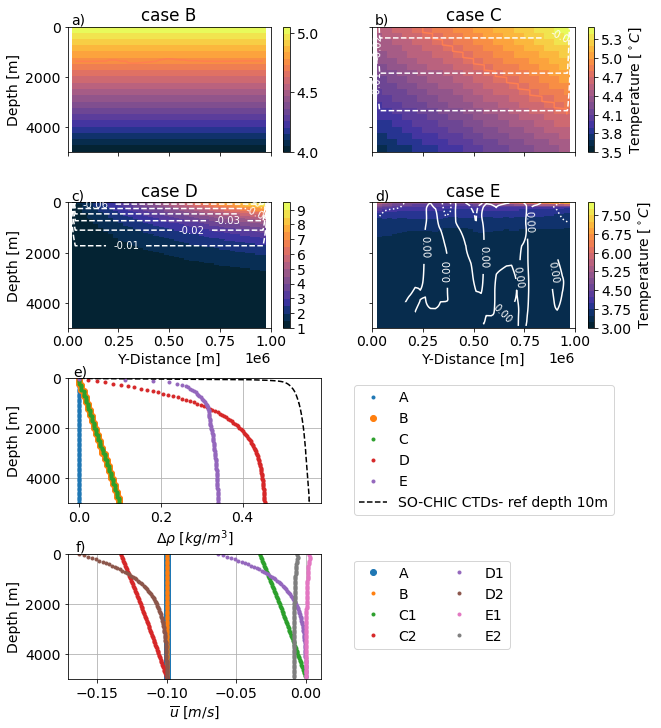

In [11]:
fig,axes=plt.subplots(4,2, figsize=(10,12),gridspec_kw={'width_ratios':[1,1],'hspace':.4})

ax0 = axes[0,0]
ax1 = axes[0,1]
ax2 = axes[1,0]
ax3 = axes[1,1]
ax31= axes[2,0]
ax4 = axes[3,0]
axes[2,1].axis('off')
axes[3,1].axis('off')

# Plot used temperature stratification
dsb2u.Temp.where(dsb2u.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=4.,vmax=5.05,levels=21,cmap=cmo.thermal,ax=ax0,cbar_kwargs={'label':'','ticks':np.linspace(4,5,3)})#,add_colorbar=False)ax=ax4)#,add_colorbar=False)
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=10,X=10).plot.contour(ax=ax0,colors=['coral'],levels=[4.75])
dsb2t.Temp.where(dsb2t.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=3.5,vmax=5.5,levels=21,ax=ax1,cmap=cmo.thermal,cbar_kwargs={'label':'Temperature [$^\circ C$]'})#,add_colorbar=False)
dsb2t.Temp.where(dsb2t.Temp>0).isel(X=10,T=0).plot.contour(levels=[4.75],ax=ax1,colors=['coral'])
dsbet.Temp.where(dsbet.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=1,vmax=9.5,levels=18,cmap=cmo.thermal,ax=ax2,cbar_kwargs={'label':''})#,add_colorbar=False)
cs1=dsb2t.U.isel(X_left=59,T=0).plot.contour(levels=np.linspace(-0.06,0,7),ax=ax1,colors='w')
cs2=dsbet.U.isel(X_left=59,T=0).plot.contour(levels=np.linspace(-0.1,0,11),ax=ax2,colors='w')
ax1.clabel(cs1, cs1.levels, inline=True,fontsize=10,fmt='%.2f')
ax2.clabel(cs2, cs2.levels, inline=True,fontsize=10,fmt='%.2f')

dsbrt.Temp.where(dsbrt.S>0).isel(X=10,T=0).plot.pcolormesh(vmin=3,vmax=8,levels=21,ax=ax3,cmap=cmo.thermal,cbar_kwargs={'label':'Temperature [$^\circ C$]'})#,add_colorbar=False)
cs4=dsbrt.U.where(dsbrt.U!=0).isel(X_left=59,T=0).plot.contour(levels=np.linspace(-0.005,0.005,3),ax=ax3,linestyles=['--','-',':'],colors='w')
ax3.clabel(cs4, cs4.levels, inline=True,fontsize=10,fmt='%.2f')

# density profiles
(dsbb.rho_hm-dsbb.rho_hm.isel(Z=0)).plot(y="Z",ax=ax31,label='A',ls='',marker='.')
(dsb2u.rho_hm-dsb2u.rho_hm.isel(Z=0)).plot(y="Z",ax=ax31,label='B',ls='',marker='o')
(dsb2t.rho_hm-dsb2t.rho_hm.isel(Z=0)).plot(y="Z",ax=ax31,label="C",ls='',marker='.')
(dsbet.rho_hm-dsbet.rho_hm.isel(Z=0)).plot(y="Z",ax=ax31,label="D",ls='',marker='.')
(dsbrt.rho_hm-dsbrt.rho_hm.isel(Z=0)).plot(y="Z",ax=ax31,label="E",ls='',marker='.')
(dso.rho_nl.mean("station").isel(depth=slice(10,None,None))-dso.rho_nl.mean("station").isel(depth=10)).plot(y="depth",color="k",ax=ax31,ls="--", label="SO-CHIC CTDs- ref depth 10m")
ax31.grid()
ax31.set_xlabel('$\Delta \\rho$ [$kg/ m^3$]')
ax31.set_ylabel('Depth [m]')
ax31.set_ylim(5000,0)
ax31.legend(bbox_to_anchor=[1.1,1])
ax31.set_title('')

# velocity profiles
(dsbb.U.where(dsbb.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label='A',ls='',marker='o')
(dsb2u.U.where(dsb2u.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label='B',ls='',marker='.')
(dsb2t.U.where(dsb2t.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label="C1",ls='',marker='.')
(dsb2tu.U.where(dsb2tu.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label="C2",ls='',marker='.')
(dsbet.U.where(dsbet.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label="D1",ls='',marker='.')
(dsbetu.U.where(dsbetu.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label="D2",ls='',marker='.')
(dsbrt.U.where(dsbrt.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label="E1",ls='',marker='.')
(dsbrtu.U.where(dsbrtu.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label="E2",ls='',marker='.')
ax4.grid()
ax4.set_xlabel('$\overline{u}$ [$m/s$]')
ax4.set_ylabel('Depth [m]')
ax4.set_ylim(5000,0)
ax4.legend(bbox_to_anchor=[1.1,1], ncol=2)
ax4.set_title('')

ax0.set_xlabel('')
ax0.set_ylabel('Depth [m]')
ax0.set_title('case B')
ax0.set_xticklabels('')

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xticklabels('')
ax1.set_yticklabels('')
ax1.set_title('case C')

ax2.set_xlabel('Y-Distance [m]')
ax2.set_ylabel('Depth [m]')
ax2.set_title('case D')

ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_yticklabels('')
ax3.set_title('case E')
ax3.set_xlabel('Y-Distance [m]')



ax0.invert_yaxis()
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()


ax0.text(0.05, 1.05, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax0.transAxes)
ax1.text(0.05, 1.05, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax1.transAxes)
ax2.text(0.05, 1.05, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax2.transAxes)
ax3.text(0.05, 1.05, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax3.transAxes)
ax31.text(0.05, 1.05,'e)', horizontalalignment='center',verticalalignment='center', transform=ax31.transAxes)
ax4.text(0.05, 1.05, 'f)', horizontalalignment='center',verticalalignment='center', transform=ax4.transAxes)

plt.tight_layout()


plt.savefig('./temp_uvel_setup_new_withoutGM.jpg',dpi=300)

# Figure 3

In [13]:
# compute barotropic velocities
dsbb['U_baro'] = (dsbb.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsbb['V_baro'] = (dsbb.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')
dsb2u['U_baro'] = (dsb2u.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsb2u['V_baro'] = (dsb2u.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')
dsb2t['U_baro'] = (dsb2t.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsb2t['V_baro'] = (dsb2t.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')

dsb2tu['U_baro'] = (dsb2tu.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsb2tu['V_baro'] = (dsb2tu.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')
dsbet['U_baro'] = (dsbet.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsbet['V_baro'] = (dsbet.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')
dsbetu['U_baro'] = (dsbetu.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsbetu['V_baro'] = (dsbetu.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')

dsbrt['U_baro'] = (dsbrt.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsbrt['V_baro'] = (dsbrt.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')
dsbrtu['U_baro'] = (dsbrtu.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsbrtu['V_baro'] = (dsbrtu.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')

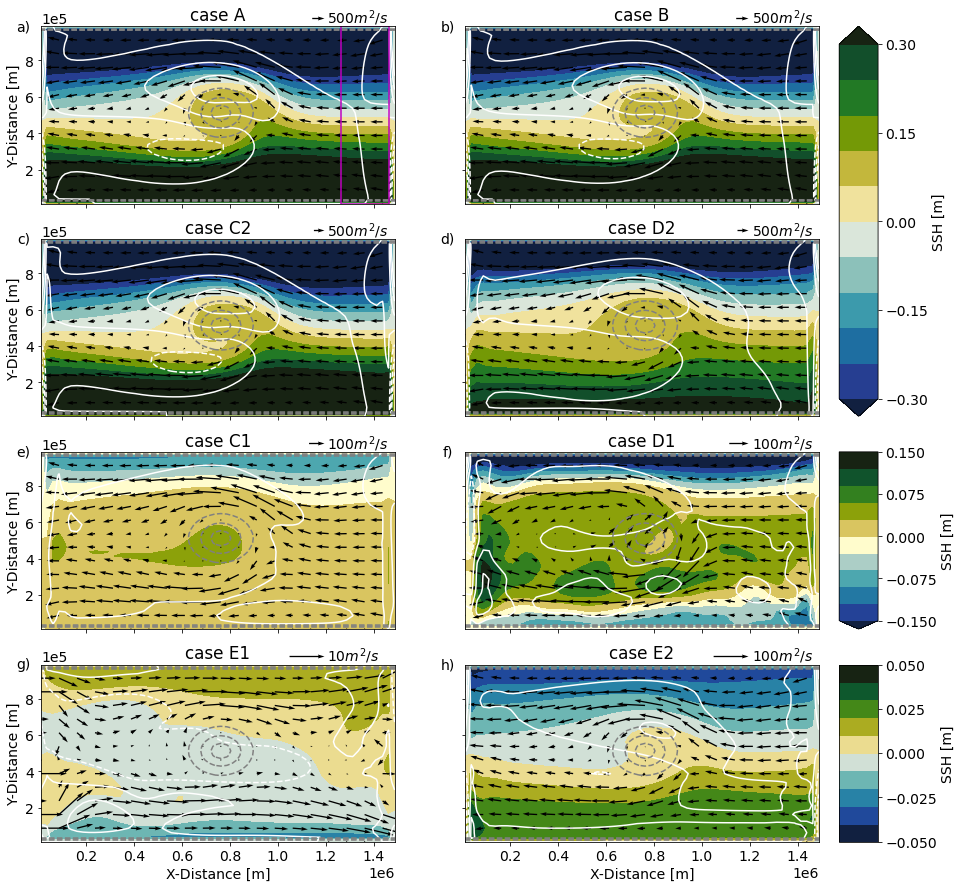

In [14]:
#plot SSH at last time step
t=-1
arr=3
cmap2=cmo.delta
lev=11
fig = plt.figure(figsize=(15,15))
gs = GridSpec(1,2, width_ratios=[1,0.05],wspace=.05)

gs1 = GridSpecFromSubplotSpec(4,2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(4,1, subplot_spec=gs[1])

wmin=-.3
wmax=-1*wmin
levl=np.linspace(wmin,wmax,7)

ax = fig.add_subplot(gs1[0,0])
dsbb.Eta.isel(T=t).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
(dsbb.Eta.isel(T=t)-dsbb.Eta.isel(T=t,X=slice(50,59)).mean(dim='X')).plot.contour(levels=levl,ax=ax,colors='w')
dsbb.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(dsbb.X[0:-1:arr],dsbb.Y[0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,500,label='$500 m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.hlines(dsbb.Y.isel(Y=0),dsbb.X.isel(X=50),dsbb.X.isel(X=58),color='m')
ax.hlines(dsbb.Y.isel(Y=39),dsbb.X.isel(X=50),dsbb.X.isel(X=58),color='m')
ax.vlines(dsbb.X.isel(X=50),dsbb.Y.isel(Y=0),dsbb.Y.isel(Y=39),color='m')
ax.vlines(dsbb.X.isel(X=58),dsbb.Y.isel(Y=0),dsbb.Y.isel(Y=39),color='m')
ax.set_title(f'case A')
ax.set_xlabel('')
ax.set_ylabel('Y-Distance [m]')
ax.set_xticklabels('')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1., 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax = fig.add_subplot(gs1[0,1])
(dsb2u.Eta.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
(dsb2u.Eta.isel(T=t)-dsb2u.Eta.isel(T=t,X=slice(50,59)).mean(dim='X')).plot.contour(levels=levl,ax=ax,colors='w')#,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsb2u.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(dsb2u.X[0:-1:arr],dsb2u.Y[0:-1:arr],grid.interp(dsb2u.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2u.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,500,label='$500 m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.set_title(f'case B')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(-0.05, 1., 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = fig.add_subplot(gs1[1,0])
(dsb2tu.Eta.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
(dsb2tu.Eta.isel(T=t)-dsb2tu.Eta.isel(T=t,X=slice(50,59)).mean(dim='X')).plot.contour(levels=levl,ax=ax,colors='w')
dsb2tu.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(dsb2tu.X[0:-1:arr],dsb2tu.Y[0:-1:arr],grid.interp(dsb2tu.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2tu.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,500,label='$500m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.set_title(f'case C2')
ax.set_ylabel('Y-Distance [m]')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1., 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = fig.add_subplot(gs1[1,1])
cb=(dsbetu.Eta.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
(dsbetu.Eta.isel(T=t)-dsbetu.Eta.isel(T=t,X=slice(50,59)).mean(dim='X')).plot.contour(levels=levl,ax=ax,colors='w')
dsbetu.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(dsbetu.X[0:-1:arr],dsbetu.Y[0:-1:arr],grid.interp(dsbetu.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbetu.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,500,label='$500m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.set_title(f'case D2')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(-0.05, 1., 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


plt.colorbar(cb,cax=fig.add_subplot(gs2[:2]), ticks=np.linspace(wmin,wmax,5),label="SSH [m]")


wmax=0.15
wmin=-1*wmax
levl=np.linspace(wmin,wmax,7)
ax = fig.add_subplot(gs1[2,0])
(dsb2t.Eta.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,extend='min',add_colorbar=False)
(dsb2t.Eta.isel(T=t)-dsb2t.Eta.isel(T=t,X=slice(50,59)).mean(dim='X')).plot.contour(levels=levl,ax=ax,colors='w')
dsb2t.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(dsb2t.X[0:-1:arr],dsb2t.Y[0:-1:arr],grid.interp(dsb2t.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2t.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,100,label='$100m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.set_title(f'case C1')
ax.set_xlabel('')
#ax.set_ylabel('')
ax.set_ylabel('Y-Distance [m]')
ax.set_xticklabels('')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1., 'e)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)




ax = fig.add_subplot(gs1[2,1])
t=122
cb1=(dsbet.Eta.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
(dsbet.Eta.isel(T=t)-dsbet.Eta.isel(T=t,X=slice(50,59)).mean(dim='X')).plot.contour(levels=levl,ax=ax,colors='w')
dsbet.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(dsbet.X[0:-1:arr],dsbet.Y[0:-1:arr],grid.interp(dsbet.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbet.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,100,label='$100m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.set_title(f'case D1')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(-0.05, 1., 'f)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

plt.colorbar(cb1,cax=fig.add_subplot(gs2[2]), ticks=np.linspace(wmin,wmax,5),label="SSH [m]")


t=-1
wmin=-0.05
wmax=-1*wmin
levl=np.linspace(wmin,wmax,11)

ax = fig.add_subplot(gs1[3,0])
(dsbrt.Eta.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
(dsbrt.Eta.isel(T=t)-dsbrt.Eta.isel(T=t,X=slice(50,59)).mean(dim='X')).plot.contour(levels=levl,ax=ax,colors='w')
dsbrt.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(dsbrt.X[0:-1:arr],dsbrt.Y[0:-1:arr],grid.interp(dsbrt.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbrt.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,10,label='$10 m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.set_title(f'case E1')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1., 'g)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = fig.add_subplot(gs1[3,1])
cb2=(dsbrtu.Eta.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
(dsbrtu.Eta.isel(T=t)-dsbrtu.Eta.isel(T=t,X=slice(50,59)).mean(dim='X')).plot.contour(levels=levl,ax=ax,colors='w')
dsbrtu.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(dsbrtu.X[0:-1:arr],dsbrtu.Y[0:-1:arr],grid.interp(dsbrtu.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbrtu.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,100,label='$100 m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.set_title(f'case E2')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.text(-0.05, 1., 'h)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

plt.colorbar(cb2,cax=fig.add_subplot(gs2[3]), ticks=np.linspace(wmin,wmax,5),label="SSH [m]")

plt.savefig('./SSH_finalstep_new_arr_withoutGM.jpg',dpi=300)

In [15]:
t=-10
a=(dsbb.Eta.isel(T=-1)-dsbb.Eta.isel(T=-1,X=58)).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
t=100
b=(dsb2u.Eta.isel(T=t)-dsb2u.Eta.isel(T=t,X=58)).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
c2=(dsb2tu.Eta.isel(T=t)-dsb2tu.Eta.isel(T=t,X=58)).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
d2=(dsbetu.Eta.isel(T=t)-dsbetu.Eta.isel(T=t,X=58)).isel(X=slice(10,-10),Y=slice(10,-5)).max().values

print((a-b)/a)
print((a-c2)/a)
print((b-c2)/b)
print((a-d2)/a)

0.054396443
0.0835329
0.030812548
0.49972522


# Figure 4

In [16]:
#compute difference in SSH by removing the thermal wind component from the full SSH
bt_comp=(dsb2tu.Eta-dsb2t.Eta)


In [17]:
t=-1
arr=3
wmin=-.3
wmax=-1*wmin
cmap2=cmo.delta
lev=21

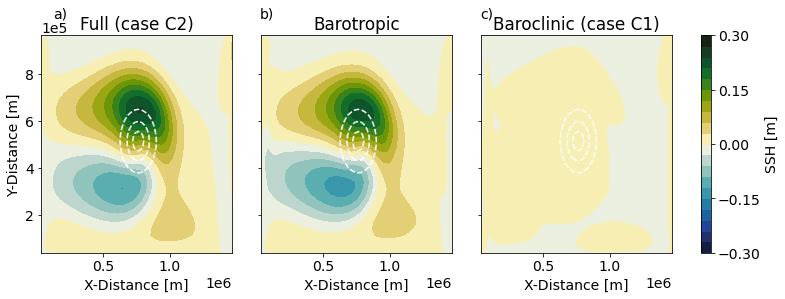

In [18]:
etamin=-0.3
etamax=0.3
etalev=21
etamap=cmo.delta
fig,axes=plt.subplots(1,4,figsize=(12,4),gridspec_kw={'width_ratios':[1,1,1,.05]})
ax=axes[0]
cb=(dsb2tu.Eta-dsb2tu.Eta.isel(T=t,X=slice(50,59)).mean(dim='X')).isel(X=slice(1,-1),Y=slice(1,-1),T=-1).plot.contourf(ax=ax,vmin=etamin,vmax=etamax,levels=etalev,cmap=etamap,add_colorbar=False)
dsb2t.Depth.isel(X=slice(1,59),Y=slice(1,-1)).plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title('Full (case C2)')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax.ticklabel_format(axis='both', style='scientific', scilimits=[-4,4])#, useOffset=None, useLocale=None, useMathText=None)
ax.text(0.1, 1.1, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax=axes[1]
(bt_comp-bt_comp.isel(T=t,X=slice(50,59)).mean(dim='X')).isel(X=slice(1,-1),Y=slice(1,-1),T=-1).plot.contourf(ax=ax,vmin=etamin,vmax=etamax,levels=etalev,cmap=etamap,add_colorbar=False)
dsb2t.Depth.isel(X=slice(1,59),Y=slice(1,-1)).plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title('Barotropic')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xlabel('X-Distance [m]')
ax.text(0.03, 1.1, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax=axes[2]
(dsb2t.Eta-dsb2t.Eta.isel(T=t,X=slice(50,59)).mean(dim='X')).isel(X=slice(1,-1),Y=slice(1,-1),T=-1).plot.contourf(ax=ax,vmin=etamin,vmax=etamax,levels=etalev,cmap=etamap,add_colorbar=False)
dsb2t.Depth.isel(X=slice(1,59),Y=slice(1,-1)).plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title('Baroclinic (case C1)')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xlabel('X-Distance [m]')
ax.text(0.03, 1.1, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

plt.colorbar(cb,cax=axes[3],label='SSH [m]',ticks=np.linspace(-0.3,0.3,5)) 
plt.savefig('./20l_split_comp_withoutGM.jpg',dpi=300)

# Figure 6

<ipython-input-20-d3d076496051>:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


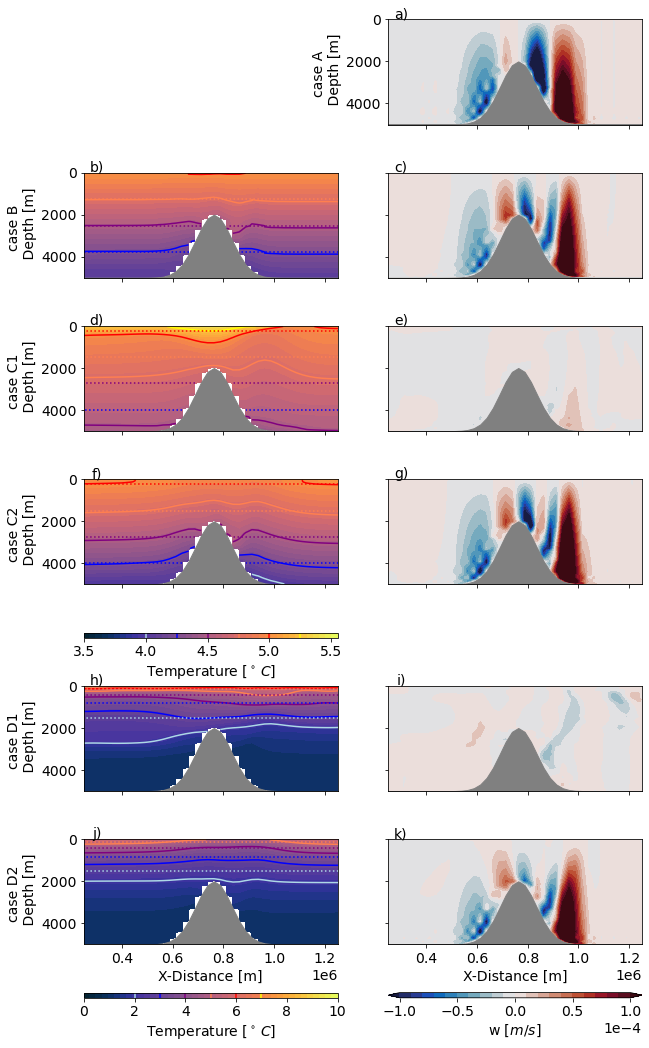

In [20]:
import matplotlib.ticker                         # here's where the formatter is
cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2))                 # set the limits for sci. not.

#plot T section  for 20 layer cases
t=-1
arr=3
tmin1=3.5
tmax1=5.55
cmapt1=cmo.thermal
levt1=43

# T for e-scale case
tmin2=0
tmax2=10
levt2=43

#plot Wsection  for 20 layer cases
wmin=-0.0001
wmax=0.0001
cmap2=cmo.balance
lev=21

fig,axes=plt.subplots(8,2,figsize=(10,18),gridspec_kw={'width_ratios':[1,1],'height_ratios':[1,1,1,1,0.05,1,1,.05],'hspace':.6})
axes[0,0].axis('off')

ax = axes[0,1]
dsbb.W.isel(T=-1,Y=20).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2u.X,(dsb2u.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('case A \n Depth [m]')
ax.set_ylim((5000,0))
ax.set_xlim((0.25e6,1.25e6))
ax.set_xticklabels('')
ax.text(0.05, 1.05, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

#---------------- case B -----------------------

ax = axes[1,0]
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=t,Y=20).plot.contourf(cmap=cmapt1,vmin=tmin1,vmax=tmax1,levels=levt1,ax=ax,add_colorbar=False)
ax.fill_between(dsb2u.X,(dsb2u.Depth).isel(Y=20),5000,color='grey')
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=0,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25],linestyles=':')
ax.set_title(f'')
ax.set_ylabel('case B \n Depth [m]')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_xlim((0.25e6,1.25e6))
ax.set_ylim((5000,0))
ax.text(0.05, 1.05, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax = axes[1,1]
dsb2u.W.isel(T=t,Y=20).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2u.X,(dsb2u.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim((5000,0))
ax.set_xlim((0.25e6,1.25e6))
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(0.05, 1.05, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

#-------------------------- case C1 ---------------------
ax = axes[2,0]
cb=(dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,Y=20)).plot.contourf(cmap=cmapt1,vmin=tmin1,vmax=tmax1,levels=levt1,ax=ax,add_colorbar=False)
dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
dsb2t.Temp.where(dsb2t.Temp>0).isel(T=0,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25],linestyles=':')
ax.fill_between(dsbb.X,(dsbb.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('case C1 \n Depth [m]')
ax.set_ylim((5000,0))
ax.set_xlim((0.25e6,1.25e6))
ax.text(0.05, 1.05, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = axes[2,1]
cb=(dsb2t.W.isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsbb.X,(dsbb.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim((5000,0))
ax.set_xlim((0.25e6,1.25e6))
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(0.05, 1.05, 'e)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


#------------------ case c2-----------------------------------

ax = axes[3,0]
cbt1=(dsb2tu.Temp.where(dsb2tu.Temp>0).isel(T=t,Y=20)).plot.contourf(cmap=cmapt1,vmin=tmin1,vmax=tmax1,levels=levt1,ax=ax,add_colorbar=False)
cctt1=dsb2tu.Temp.where(dsb2tu.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
dsb2tu.Temp.where(dsb2tu.Temp>0).isel(T=0,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25],linestyles=':')
ax.fill_between(dsb2tu.X,(dsb2tu.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('case C2 \n Depth [m]')
ax.set_ylim((5000,0))
ax.set_xlim((0.25e6,1.25e6))
ax.text(0.05, 1.05, 'f)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax =  axes[3,1]
cb=(dsb2tu.W.isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2tu.X,(dsb2tu.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylim((5000,0))
ax.set_xlim((0.25e6,1.25e6))
ax.text(0.05, 1.05, 'g)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

cbar1=plt.colorbar(cbt1,cax=axes[4,0],orientation="horizontal",label='Temperature [$^\circ\,C$]',ticks=np.linspace(3.5,5.5,5))
cbar1.add_lines(cctt1)
axes[4,1].axis('off')

# ------------case D1 --------------------------------------

ax = axes[5,0]
dsbet.Temp.where(dsbet.Temp>0).isel(T=t,Y=20).plot.contourf(cmap=cmapt1,vmin=tmin2,vmax=tmax2,levels=levt2,ax=ax,add_colorbar=False)
ax.fill_between(dsbet.X,(dsb2u.Depth).isel(Y=20),5000,color='grey')
dsbet.Temp.where(dsbet.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[2,3,4,5,6,7])
dsbet.Temp.where(dsbet.Temp>0).isel(T=0,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[2,3,4,5,6,7],linestyles=':')
ax.set_title(f'')
ax.set_xlabel('')#X-Distance [m]')
ax.set_ylabel('case D1 \n Depth [m]')
ax.set_xticklabels('')
ax.set_ylim((5000,0))
ax.set_xlim((0.25e6,1.25e6))
ax.text(0.05, 1.05, 'h)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = axes[5,1]
dsbet.W.isel(T=t,Y=20).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsbet.X,(dsb2u.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.set_ylabel('')
ax.set_ylim((5000,0))
ax.set_xlim((0.25e6,1.25e6))
ax.text(0.05, 1.05, 'i)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


# ------------------ case D2 ----------------------------
ax =axes[6,0]
cbt2=(dsbetu.Temp.where(dsbetu.Temp>0).isel(T=t,Y=20)).plot.contourf(cmap=cmapt1,vmin=tmin2,vmax=tmax2,levels=levt2,ax=ax,add_colorbar=False)
cctt2=dsbetu.Temp.where(dsbetu.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[2,3,4,5,6,7])
dsbetu.Temp.where(dsbetu.Temp>0).isel(T=0,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[2,3,4,5,6,7],linestyles=':')
ax.fill_between(dsbb.X,(dsbb.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('case D2 \n Depth [m]')
ax.set_ylim((5000,0))
ax.set_xlim((0.25e6,1.25e6))
ax.text(0.05, 1.05, 'j)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = axes[6,1]
cbw=(dsbetu.W.isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsbb.X,(dsbb.Depth).isel(Y=20),5000,color='grey')
#ax.set_title(f' e-scale \n thermal wind + uniform \n day: {dsbetu.day.isel(T=t).values}')
ax.set_title(f'')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_ylim((5000,0))
ax.set_xlim((0.25e6,1.25e6))
ax.set_yticklabels('')
ax.text(0.05, 1.05, 'k)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


cbar2=plt.colorbar(cbt2,cax=axes[7,0], orientation="horizontal",label='Temperature [$^\circ\,C$]',ticks=np.linspace(tmin2,tmax2,6))
cbar2.add_lines(cctt2)
cbar3=plt.colorbar(cbw,cax=axes[7,1], orientation="horizontal", ticks=np.linspace(wmin,wmax,5),label="w [$m/s$]",format=cbformat)

plt.tight_layout()
plt.savefig('./TW_sections_alongx_withoutGM.jpg',dpi=300)

# compute Burger number

In [52]:
H=5000
L=100000
#constants through out this notebook
g=9.81
f=gsw.f(-65) 
alpha0=1e-4
rho0=1035


# Burger number computation when each layer has a different stratification
def Burger(Temp):
    rho=rho0- rho0*alpha0*Temp.isel(T=0)
    rho=xr.where(rho==rho0,np.nan,rho)
    N=np.sqrt((-g/rho0)*(rho.diff(dim='Z')/-50)) #*grid1.derivative(ds1.rho,'Z'))
    N_mean=N.isel(X=slice(1,-1),Y=slice(1,-1)).mean(dim={'X','Y','Z'})
    Bu=(N_mean*H/(np.abs(f)*L))
    return Bu

# Burger number if layers are several gridcells thick
def Burgerl(Temp):
    rho=rho0- rho0*alpha0*Temp.isel(T=0)
    rho=xr.where(rho==rho0,np.nan,rho)
    N=np.sqrt((-g/rho0)*(rho.diff(dim='Z')/-50)) #*grid1.derivative(ds1.rho,'Z'))
    N_mean=N.isel(X=slice(1,-1),Y=slice(1,-1), Z=slice(4,-1,5)).mean(dim={'X','Y','Z'})
    Bu=(N_mean*H/(np.abs(f)*L))
    return Bu

In [53]:
dsbb['Bu']=Burger(dsbb.Temp)

dsb2u['Bu']=Burgerl(dsb2u.Temp)
dsb2t['Bu']=Burgerl(dsb2t.Temp)
dsb2tu['Bu']=Burgerl(dsb2tu.Temp)
dsbet['Bu']=Burger(dsbet.Temp)
dsbetu['Bu']=Burger(dsbetu.Temp)
dsbrt['Bu']=Burger(dsbrt.Temp)
dsbrtu['Bu']=Burger(dsbrtu.Temp)





In [54]:
print('A:',dsbb.Bu.values)
print('B:',dsb2u.Bu.values)
print('C1:',dsb2t.Bu.values)
print('C2:',dsb2tu.Bu.values)
print('D1:',dsbet.Bu.values)
print('D2:',dsbetu.Bu.values)
print('E1:',dsbrt.Bu.values)
print('E2:',dsbrtu.Bu.values)



A: 0.0
B: 0.37455094
C1: 0.3745315
C2: 0.3745315
D1: 0.27899832
D2: 0.27899832
E1: 0.17306738
E2: 0.17306738
